In [122]:
!python -m pip install -U setuptools pip
!pip install kornia

In [123]:
from __future__ import print_function
from PIL import Image
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import kornia
import scipy
import imageio
import os

epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [124]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [125]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [126]:
# Train upscale model
!python main.py --cuda --upscale_factor 10 --batchSize 100 --testBatchSize 100 --nEpochs 50 --lr 0.001

Namespace(batchSize=100, cuda=True, lr=0.001, nEpochs=50, resume='', seed=123, testBatchSize=100, threads=8, upscale_factor=10)
===> Loading datasets
===> Building model
===> Epoch[1](1/2): Loss: 0.3362
===> Epoch[1](2/2): Loss: 0.2244
===> Epoch 1 Complete: Avg. Loss: 0.2803
===> Avg. PSNR: 7.4628 dB
Checkpoint saved to model_epoch_1.pth
===> Epoch[2](1/2): Loss: 0.1810
===> Epoch[2](2/2): Loss: 0.1432
===> Epoch 2 Complete: Avg. Loss: 0.1621
===> Avg. PSNR: 8.8776 dB
Checkpoint saved to model_epoch_2.pth
===> Epoch[3](1/2): Loss: 0.1293
===> Epoch[3](2/2): Loss: 0.1072
===> Epoch 3 Complete: Avg. Loss: 0.1182
===> Avg. PSNR: 10.2937 dB
Checkpoint saved to model_epoch_3.pth
===> Epoch[4](1/2): Loss: 0.0907
===> Epoch[4](2/2): Loss: 0.0759
===> Epoch 4 Complete: Avg. Loss: 0.0833
===> Avg. PSNR: 11.8383 dB
Checkpoint saved to model_epoch_4.pth
===> Epoch[5](1/2): Loss: 0.0641
===> Epoch[5](2/2): Loss: 0.0552
===> Epoch 5 Complete: Avg. Loss: 0.0596
===> Avg. PSNR: 12.8865 dB
Checkpoint

In [127]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    Adv_correct = 0
    adv_examples = []

    Fix_correct = 0
    Fix_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            Adv_correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

        ##########################
        # Attempt to fix
        ##########################
        gauss = kornia.filters.GaussianBlur2d((3,3), (1.5,1.5))

        perturbed_data = gauss(perturbed_data)

        ##########################
        # Upscale image back
        ##########################

        upres_model = torch.load('/content/model_epoch_50.pth')
        upres_model = upres_model['arch']
        upres_input = perturbed_data

        upres_use_cuda = True

        if upres_use_cuda:
            upres_model = upres_model.cuda()
            upres_input = upres_input.cuda()

        upres_out = upres_model(upres_input)

        # Create grid
        out_size = 28
        x = torch.linspace(-1, 1, out_size).view(-1, 1).repeat(1, out_size)
        y = torch.linspace(-1, 1, out_size).repeat(out_size, 1)
        grid = torch.cat((x.unsqueeze(2), y.unsqueeze(2)), 2).cuda()
        grid.unsqueeze_(0)
        upres_out = F.grid_sample(upres_out, grid)
        
        output = model(upres_out)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            Fix_correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(Fix_examples) < 5):
                fix_ex = perturbed_data.squeeze().detach().cpu().numpy()
                Fix_examples.append( (init_pred.item(), final_pred.item(), fix_ex) )
        else:
            # Save some adv examples for visualization later
            if len(Fix_examples) < 5:
                fix_ex = perturbed_data.squeeze().detach().cpu().numpy()
                Fix_examples.append( (init_pred.item(), final_pred.item(), fix_ex) )
        ##########################


    # Calculate final accuracy for this epsilon
    Adv_final_acc = Adv_correct/float(len(test_loader))
    print("Epsilon: {}\tAdv Test Accuracy = {} / {} = {}".format(epsilon, Adv_correct, len(test_loader), Adv_final_acc))

    Fix_final_acc = Fix_correct/float(len(test_loader))
    print("Epsilon: {}\tFixed Test Accuracy = {} / {} = {}".format(epsilon, Fix_correct, len(test_loader), Fix_final_acc))
    

    # Return the accuracy and an adversarial example
    return Adv_final_acc, adv_examples, Fix_final_acc, Fix_examples

In [128]:
Adv_accuracies = []
Adv_examples = []
Fix_accuracies = []
Fix_examples = []

# Run test for each epsilon
for eps in epsilons:
    adv_acc, adv_ex, fix_acc, fix_ex = test(model, device, test_loader, eps)
    Adv_accuracies.append(adv_acc)
    Adv_examples.append(adv_ex)
    Fix_accuracies.append(fix_acc)
    Fix_examples.append(fix_ex)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Epsilon: 0	Adv Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0	Fixed Test Accuracy = 1509 / 10000 = 0.1509
Epsilon: 0.05	Adv Test Accuracy = 9425 / 10000 = 0.9425
Epsilon: 0.05	Fixed Test Accuracy = 1509 / 10000 = 0.1509
Epsilon: 0.1	Adv Test Accuracy = 8512 / 10000 = 0.8512
Epsilon: 0.1	Fixed Test Accuracy = 1508 / 10000 = 0.1508
Epsilon: 0.15	Adv Test Accuracy = 6847 / 10000 = 0.6847
Epsilon: 0.15	Fixed Test Accuracy = 1525 / 10000 = 0.1525
Epsilon: 0.2	Adv Test Accuracy = 4335 / 10000 = 0.4335
Epsilon: 0.2	Fixed Test Accuracy = 1546 / 10000 = 0.1546
Epsilon: 0.25	Adv Test Accuracy = 2103 / 10000 = 0.2103
Epsilon: 0.25	Fixed Test Accuracy = 1560 / 10000 = 0.156
Epsilon: 0.3	Adv Test Accuracy = 881 / 10000 = 0.0881
Epsilon: 0.3	Fixed Test Accuracy = 1561 / 10000 = 0.1561


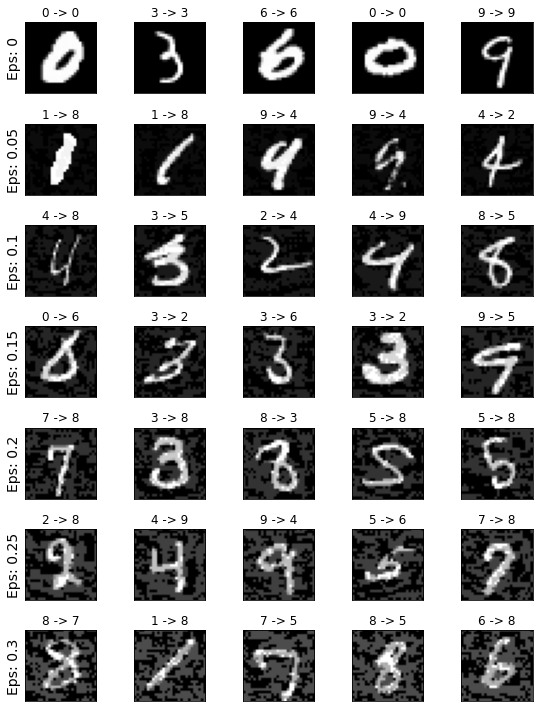

In [129]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(Adv_examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(Adv_examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = Adv_examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

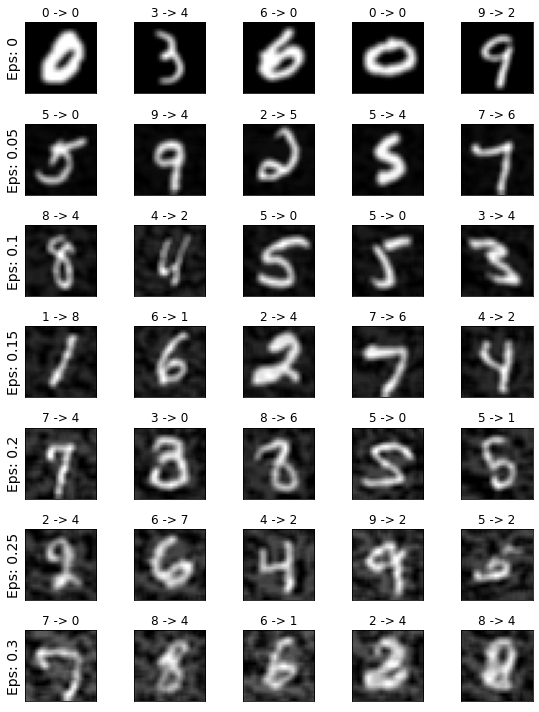

In [130]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(Fix_examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(Fix_examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = Fix_examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()